## MAT 653 
#### Wei Li

### EM algorithm for missing data

Original code credits: Kevin Murphy.


In [1]:
# Illustrate imputation of an N*D partially observed data matrix by fitting a Gaussian using EM and then predicting missing entries
# authors: Drishttii@, murphyk@

# try:
#     import probml_utils as pml
# except ModuleNotFoundError:
#     %pip install -qq git+https://github.com/probml/probml-utils.git
#     import probml_utils as pml

# import probml_utils.gauss_utils as gauss


import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_spd_matrix
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

np.random.seed(4)

In [2]:
def gauss_sample(mu, sigma, n):
    """
    Generate random samples from a multivariate Gaussian distribution.
    
    Parameters
    ----------
    mu : array-like
        The mean vector of the multivariate Gaussian distribution, shape (d,).
    sigma : array-like
        The covariance matrix of the multivariate Gaussian distribution, shape (d, d).
    n : int
        The number of samples to generate.
        
    Returns
    -------
    np.ndarray
        An array of shape (n, d) containing the random samples.
    """
    
    # Compute the Cholesky decomposition of the covariance matrix
    # 'a' will be a lower triangular matrix
    a = np.linalg.cholesky(sigma)
    
    # Generate standard normal random samples, shape (d, n)
    # where 'd' is the dimensionality of the multivariate Gaussian
    z = np.random.randn(len(mu), n)
    
    # Multiply the Cholesky matrix with the standard normal samples
    # Result 'k' will have shape (d, n)
    k = np.dot(a, z)
    
    # Translate the samples by adding the mean
    # Finally, transpose the resulting matrix to get shape (n, d)
    return np.transpose(mu + k)


def gauss_condition(mu, sigma, visible_nodes, visible_values):
    """
    Calculate the conditional mean and covariance for a multivariate Gaussian
    given some observed variables.

    Parameters
    ----------
    mu : array-like
        The mean vector of the multivariate Gaussian distribution, shape (d,).
    sigma : array-like
        The covariance matrix of the multivariate Gaussian distribution, shape (d, d).
    visible_nodes : array-like
        The indices of observed variables, shape (k,).
    visible_values : array-like
        The observed values for the variables in visible_nodes, shape (k,).

    Returns
    -------
    mugivh : array-like
        The conditional mean vector given the observed values, shape (d-k,).
    sigivh : array-like
        The conditional covariance matrix given the observed values, shape (d-k, d-k).
    """

    # Determine the total number of variables 'd'
    d = len(mu)
    
    # Generate an array 'j' containing all variable indices [0, 1, ..., d-1]
    j = np.array(range(d))

    # Reshape visible_nodes to a 1D array, indices of observed variables
    v = visible_nodes.reshape(len(visible_nodes))

    # Find the set of hidden/latent variables by subtracting visible nodes from all nodes
    h = np.setdiff1d(j, v)
    # numpy.setdiff1d return the unique values in ar1 that are not in ar2.

    # If all nodes are observed
    if len(h) == 0:
        mugivh = np.array([])
        sigivh = np.array([])
    
    # If no nodes are observed
    elif len(v) == 0:
        mugivh = mu
        sigivh = sigma

    else:
        # Extract the relevant parts of the covariance matrix
        # The function np.ix_ takes two 1-D numpy arrays and returns an open mesh, 
        # which is essentially a pair of arrays that can be used to index into another
        #  multi-dimensional array based on the input arrays.
        ndx_hh = np.ix_(h, h)
        sigma_hh = sigma[ndx_hh]
        
        ndx_hv = np.ix_(h, v)
        sigma_hv = sigma[ndx_hv]

        ndx_vv = np.ix_(v, v)
        sigma_vv = sigma[ndx_vv]

        # Invert the observed-observed covariance matrix
        sigma_vv_inv = np.linalg.inv(sigma_vv)

        # Reshape visible_values for matrix operations
        visible_values_len = len(visible_values)

        # Compute conditional mean
        mugivh = mu[h] + np.dot(
            sigma_hv, 
            np.dot(
                sigma_vv_inv, 
                (visible_values.reshape((visible_values_len, 1)) - mu[v].reshape((visible_values_len, 1)))
            )
        )

        # Compute conditional covariance
        sigivh = sigma_hh - np.dot(
            sigma_hv, 
            np.dot(
                sigma_vv_inv, 
                np.transpose(sigma_hv)
            )
        )

    return mugivh, sigivh


In [3]:
def gauss_impute(mu, sigma, x):
    """
    Impute missing values in a dataset using Gaussian conditioning.
    
    Parameters:
        mu (array-like): The mean vector of the Gaussian distribution.
        sigma (array-like): The covariance matrix of the Gaussian distribution.
        x (array-like): The data matrix (n by dim) with missing values (represented by NaNs).
        
    Returns:
        array-like: The data matrix (n by dim) with imputed values.
    """
    
    # Get the shape of the input data matrix
    n_data, data_dim = x.shape
    
    # Initialize the output matrix with the input matrix
    x_imputed = np.copy(x)
    
    # Loop through each data point (row) in the data matrix
    for i in range(n_data):
        
        # Identify indices of hidden (missing) and visible (observed) variables for the i-th data point
        hidden_nodes = np.argwhere(np.isnan(x[i, :]))
        visible_nodes = np.argwhere(~np.isnan(x[i, :]))
        
        # Initialize array to store values of visible (observed) variables
        visible_values = np.zeros(len(visible_nodes))
        
        # Populate visible_values with the observed values from the i-th data point
        for tc, h in enumerate(visible_nodes):
            visible_values[tc] = x[i, h]
        
        # Get the conditional mean and covariance for the hidden variables given the visible ones
        mu_hgv, sigma_hgv = gauss_condition(mu, sigma, visible_nodes, visible_values)
        
        # Impute the missing values for the i-th data point using the conditional mean
        for rr, h in enumerate(hidden_nodes):
            x_imputed[i, h] = mu_hgv[rr]
            
    return x_imputed



In [4]:

def gauss_fit_em(X, max_iter=50, eps=1e-04):
    """
    Compute the maximum likelihood estimate (MLE) of a multivariate Gaussian distribution
    given a dataset with missing values using the Expectation-Maximization (EM) algorithm.
    
    Parameters:
        X (numpy.ndarray): The data matrix with missing values represented by NaNs.
        max_iter (int): Maximum number of iterations for the EM algorithm.
        eps (float): Convergence tolerance.
        
    Returns:
        dict: A dictionary containing the estimated 'mu' (mean), 'Sigma' (covariance matrix),
              and 'niter' (number of iterations until convergence).
    """
    
    nr, nc = X.shape  # Number of rows and columns in the data matrix X
    
    # Identify observed and missing entries in X
    C = np.isnan(X) == False  # C indicates observed entries (1=observed)
    e = 0.0000001  # Small epsilon value to avoid division by zero


    one_to_nc = np.arange(1, nc + 1, step=1) # 1D-array from 1, 2, to nc (inclusive)

    # Indices of Missing and Observed locations
    # M is (nr, nc) matrix of indices of missing locations (index uses 0 as the base)
    M = one_to_nc * (C == False) - 1   #  (-1 at locations where Nan is not present in X)
    # one_to_nc * (C == False) broadcasting from (nc,)*(nr, nc) to (nr, nc)*(nr, nc)
    
    # O is (nr, nc) matrix of indices of observed locations (index uses 0 as the base)
    O = one_to_nc * C - 1  # Observed locations (-1 at locations where Nan is present in X)
    
    # Initial estimates of Mu and Sigma
    Mu = np.nanmean(X, axis=0).reshape(-1, 1) # Mu = (nc, 1)
    # np.nanmean compute mean ignoring nan
    Mu_new = Mu.copy()
    # observed_rows stores the row indices of X such that the row are fully observed
    observed_rows = np.where(np.isnan(sum(X.T)) == False)[0]

    # S is sample covariance of using only the complete data (rows)
    S = np.cov(X[observed_rows,].T)

    # This checks if the covariance matrix S has any NaN values. This might happen
    # if X had only one observed row, or if the variance of some feature was zero 
    # (leading to a division by zero in some implementations).
    # If S contains any NaN, this line computes the variance along each feature 
    # (ignoring NaN values) and places these variances along the diagonal of a 
    # new matrix S. This assumes that all features are independent, which is likely a simplification.
    if np.isnan(S).any():
        S = np.diag(np.nanvar(X, axis=0))
    S_new = S.copy()

    # Start of EM iterations
    X_tilde = X.copy()
    no_conv = True
    iteration = 0

    while no_conv and iteration < max_iter:
        # E-step: Compute the expected sufficient statistics given current parameters
        EX = np.zeros((nc, 1)) # temporay expected E(X| X_obs) for the current row
        EXX = np.zeros((nc, nc)) # temporay expected E(XX'| X_obs) for the current row
        EXsum = np.zeros((nc, 1)) # expected E(X| X_obs)
        EXXsum = np.zeros((nc, nc)) # expected E(XX'| X_obs)
        
        # update the current values of Mu and S
        Mu = Mu_new
        S = S_new
        
        for i in range(nr):
            # iterates over all rows

            if set(O[i,]) != set(one_to_nc - 1):  # If there are missing components
                # For rows with no missing values, these statistics are directly observed and, 
                # therefore, do not need to be estimated. These rows already contribute
                # to the initial calculations of Mu and S (mean and covariance), 
                # which are used as the starting points for the EM algorithm.
                
                # Indices for missing and observed entries for the i-th data point
                m_indx = M[i,] != -1
                o_indx = O[i,] != -1
                M_i = M[i,][m_indx] # M_i indices for the missing entry in the i-th data point
                O_i = O[i,][o_indx] # O_i indices for the observed entry in the i-th data point
                
                # Calculate expected mean and variance for the missing entries
                Mui = Mu[np.ix_(M_i)] + (S[np.ix_(M_i, O_i)] @ np.linalg.pinv(S[np.ix_(O_i, O_i)] + e) @ (
                            X_tilde[i, np.ix_(O_i)].T - Mu[np.ix_(O_i)]))  # Expected stats for mean
                
                Vi = S[np.ix_(M_i, M_i)] - S[np.ix_(M_i, O_i)] @ np.linalg.inv(S[np.ix_(O_i, O_i)] + e) @ S[
                    np.ix_(M_i, O_i)].T  # Expected stats for sigma
                
                Mui = Mui.reshape(-1, 1) # shape (num_missing, 1)               
                
                # Update expected sufficient statistics
                EX[np.ix_(O_i)] = X_tilde[i, np.ix_(O_i)].T
                EX[np.ix_(M_i)] = Mui

                EXX[np.ix_(M_i, M_i)] = EX[np.ix_(M_i)] * EX[np.ix_(M_i)].T + Vi
                EXX[np.ix_(O_i, O_i)] = EX[np.ix_(O_i)] * EX[np.ix_(O_i)].T
                EXX[np.ix_(O_i, M_i)] = EX[np.ix_(O_i)] * EX[np.ix_(M_i)].T
                EXX[np.ix_(M_i, O_i)] = EX[np.ix_(M_i)] * EX[np.ix_(O_i)].T
                
                EXsum = EXsum + EX
                EXXsum = EXXsum + EXX
                
        # M-step: Update parameters based on the expected sufficient statistics
        Mu_new = EXsum / (nr-len(observed_rows ))
        S_new = EXXsum / (nr-len(observed_rows )) - Mu_new * Mu_new.T

        # Check for convergence
        no_conv = np.linalg.norm(Mu - Mu_new) >= eps or np.linalg.norm(S - S_new, ord=2) >= eps
        iteration += 1

    return {'mu': Mu, 'Sigma': S, 'niter': iteration}




In [5]:
data_dim = 4 # data has four predictors
n_data = 1000
threshold_missing = 0.3
mu = np.random.randn(data_dim, 1)

sigma = make_spd_matrix(n_dim=data_dim) # Generate a random symmetric, positive-definite matrix.
x_full = gauss_sample(mu, sigma, n_data)
missing = np.random.rand(n_data, data_dim) < threshold_missing
x_miss = np.copy(x_full)
x_miss[missing] = np.nan # use np.nan as missing values

# use the true mu and sigma to impute the missing values
x_impute_oracle = gauss_impute(mu, sigma, x_miss)

# use EM algorithm to estiamte mu and sigma
result = gauss_fit_em(x_miss, max_iter=1000, eps=1e-15)
m = result.get("mu")
sig = result.get("Sigma")
x_impute_em = gauss_impute(m, sig, x_miss)



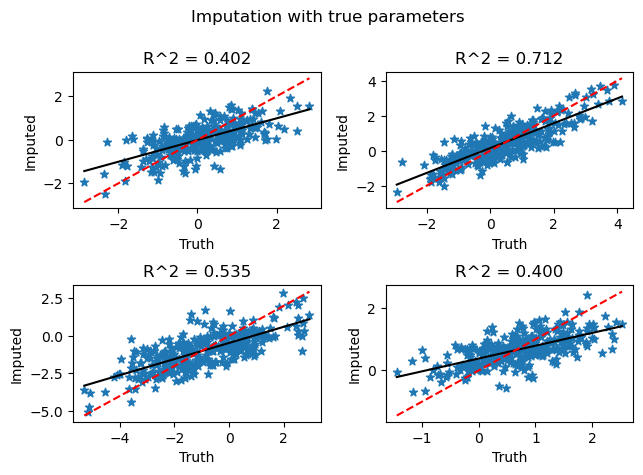

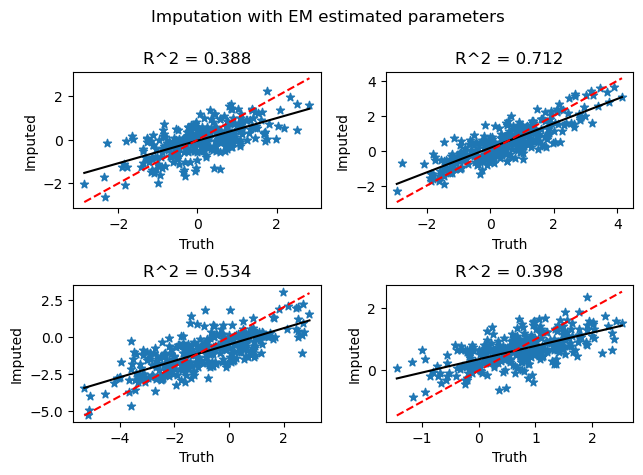

In [6]:
def plot_performance(x_miss, x_full, x_impute):
    r_squared = []
    for i in range(4):
        miss = np.argwhere(np.isnan(x_miss[:, i]))
        r2 = r2_score(x_full[miss, i], x_impute[miss, i])
        r_squared.append(r2)

    fig, axs = plt.subplots(nrows=2, ncols=2)
    axs = axs.reshape(4)
    reg = LinearRegression()
    for i in range(4):
        miss = np.argwhere(np.isnan(x_miss[:, i]))
        min_val = x_full[miss, i].min()  # Changed variable name to avoid shadowing the built-in min() function
        max_val = x_full[miss, i].max()  # Changed variable name to avoid shadowing the built-in max() function
        xtest = np.linspace(min_val, max_val, 50).reshape(-1, 1)
        model = reg.fit(x_full[miss, i], x_impute[miss, i])
        line = model.predict(xtest)

        ax = axs[i]
        ax.plot(xtest, line, color="black", label='Regression Line')
        ax.plot([min_val, max_val], [min_val, max_val], linestyle='--', color='red', label='45-degree Line')  # 45-degree line
        ax.scatter(x_full[miss, i], x_impute[miss, i], marker="*", label='Data Points')
        ax.set_title("R^2 = %5.3f" % (r_squared[i]))
        ax.set_xlabel("Truth")
        ax.set_ylabel("Imputed")
        #ax.legend()  # Optional, to show labels for the lines and scatter points

    plt.tight_layout()
    return fig

fig = plot_performance(x_miss, x_full, x_impute_oracle)
fig.suptitle("Imputation with true parameters")
fig.tight_layout()
fig.subplots_adjust(top=0.85)
plt.show()


fig = plot_performance(x_miss, x_full, x_impute_em)
fig.suptitle("Imputation with EM estimated parameters")
fig.tight_layout()
fig.subplots_adjust(top=0.85)
plt.show()

Each plot is for one dimension of $x$. Each scatter point represents a data point where a value was missing. The x-coordinate is the true value, and the y-coordinate is the imputed value.  A regression line (black) is fitted to the scatter points. Notice the the difference between using the true parameter values and the imputed values is small. 

The closer this line is to a 45-degree diagonal (red dashed line), the better the imputation. Yet remember even the true distribution can only provide an expectation of what the missing value should be, not the exact value; the imputed values are just randomly generated centering at the expectation.